In [15]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def emi_map(dataset, var_name, title):

    #TODO add possibility to plot at user defined time.
    #TODO add optional arg for admin data?.

    var = dataset[var_name]

    # draw map
    ax = plt.subplot(projection=ccrs.PlateCarree())

    # draw coastlines and borders
    #ax.add_feature(cfeature.COASTLINE, lw=0.5)
    ax.add_feature(cfeature.BORDERS, lw=0.5)
    ax.add_feature(cfeature.COASTLINE, lw=0.5)
    # draw administrative areas.  

    # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
    fname ='/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp'

    provinces = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(provinces, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=0.5,
                      lw=0.5)

    # draw meridians and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.5, color='k', alpha=0.4)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}

    # plot data
    long = dataset.XLAT.values[0,:, :]
    lat = dataset.XLONG.values[0,:, :]
    var_values = var[0,:, :]



    res = 15  # controls the resolution for the map plotting.
    cs = plt.contourf(lat, long, var_values, res,
         transform=ccrs.PlateCarree(), cmap=plt.cm.bone_r)

    # colorbar settings
    cbar = plt.colorbar(cs)  # pad=0.2 #format='%.2e'
    cbar.set_label(var.units)
    ax.set_title(title)

    plt.show()

In [17]:
def time_mean(ds):
    return xr.Dataset(dict(ds.mean(dim='Time', keep_attrs=True).data_vars), coords = dict(ds.coords))

In [18]:
def space_mean(ds):
     return xr.Dataset(dict(ds.mean(dim= ['south_north','west_east'],keep_attrs=True).data_vars), coords=dict(ds.coords))

## FIRE EMISSIONS

In [19]:
#Emissions
fire ='/geos/d21/s1878599/IGP/inputs/autumn/base/wrffirechemi*'
dsf = xr.open_mfdataset(fire, concat_dim='Time')

In [20]:
#Adding XLAT and XLONG to dataset
datapath ='/geos/d21/s1878599/IGP/outputs/autumn/base/wrfout_d01_2017-10-18_00:00:00_.nc'
ds = xr.open_dataset(datapath)
#reshaping XLAT and LONG to ds_fire sizes.
lat =np.resize(ds.XLAT.values,dsf.ebu_in_co.shape)
long =np.resize(ds.XLONG.values,dsf.ebu_in_co.shape)

#adding to ds_fire
dsf['XLAT'] = xr.DataArray(lat, dims = dsf.dims)
dsf['XLONG'] = xr.DataArray(long, dims = dsf.dims)

In [21]:
# Adding sum up of NOx
dsf["NOx"]=dsf.ebu_in_no + dsf.ebu_in_no2
dsf.NOx.attrs["units"]="mole km-2 hr-1"

In [9]:
# Adding sum up of all NMVOC
dsf["NMVOC"] = \
dsf.ebu_in_bigalk + dsf.ebu_in_isop +\
dsf.ebu_in_bigene + dsf.ebu_in_macr +\
dsf.ebu_in_c2h4 +   dsf.ebu_in_mvk +\
dsf.ebu_in_c2h5oh + dsf.ebu_in_apin +\
dsf.ebu_in_c2h6 +   dsf.ebu_in_ch3cn +\
dsf.ebu_in_c3h8 +   dsf.ebu_in_hcn +\
dsf.ebu_in_c3h6 +      dsf.ebu_in_hcooh +\
dsf.ebu_in_ch2o +      dsf.ebu_in_c2h2 +\
dsf.ebu_in_ch3cho +   dsf.ebu_in_ch3coch3 +\
dsf.ebu_in_ch3oh +    dsf.ebu_in_mek +\
dsf.ebu_in_toluene +  dsf.ebu_in_benzene +\
dsf.ebu_in_xylene +   dsf.ebu_in_xylenes +\
dsf.ebu_in_open +     dsf.ebu_in_c10h16 +\
dsf.ebu_in_ch3cooh +  dsf.ebu_in_cres +\
dsf.ebu_in_glyald +   dsf.ebu_in_mgly +\
dsf.ebu_in_acetol 

dsf.NMVOC.attrs["units"]="mole km-2 hr-1"

In [10]:
# Adding Total fire size
dsf["tot_firesize"]=dsf.FIRESIZE_AGEF + dsf.FIRESIZE_AGTF+dsf.FIRESIZE_AGSV +dsf.FIRESIZE_AGGR
dsf.tot_firesize.attrs["units"]="m2"

In [14]:
dsf.ebu_in_pm25

<xarray.DataArray 'ebu_in_pm25' (Time: 888, emissions_zdim_stag: 1, south_north: 119, west_east: 159)>
dask.array<concatenate, shape=(888, 1, 119, 159), dtype=float32, chunksize=(1, 1, 119, 159), chunktype=numpy.ndarray>
Dimensions without coordinates: Time, emissions_zdim_stag, south_north, west_east
Attributes:
    MemoryOrder:  XYZ
    description:  EMISSIONS
    units:        ug m-2 s-1
    stagger:      Z
    FieldType:    104

In [48]:
t_dsf=time_mean(dsf)

In [52]:
t_dsf.NMVOC

<xarray.DataArray 'NMVOC' (emissions_zdim_stag: 1, south_north: 119, west_east: 159)>
dask.array<mean_agg-aggregate, shape=(1, 119, 159), dtype=float32, chunksize=(1, 119, 159), chunktype=numpy.ndarray>
Dimensions without coordinates: emissions_zdim_stag, south_north, west_east
Attributes:
    units:    mole km-2 hr-1

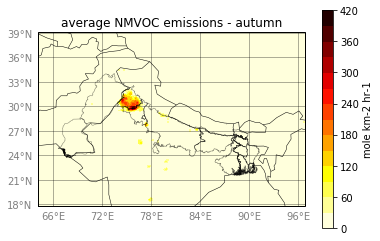

In [40]:
emi_map(t_dsf, "NMVOC", "average NMVOC emissions - autumn")

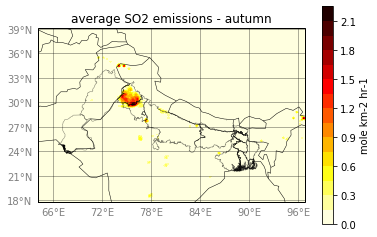

In [41]:
emi_map(t_dsf, "ebu_in_so2", "average SO2 emissions - autumn")

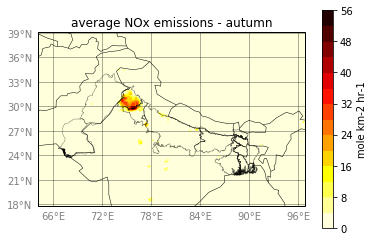

In [43]:
emi_map(t_dsf, "NOx", "average NOx emissions - autumn")

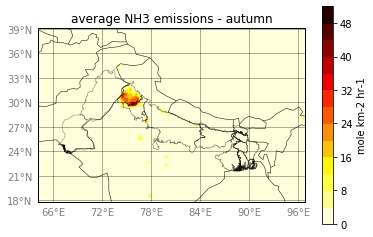

In [44]:
emi_map(t_dsf, "ebu_in_nh3", "average NH3 emissions - autumn")

In [49]:
t_dsf.tot_firesize

<xarray.DataArray 'tot_firesize' (south_north: 119, west_east: 159)>
dask.array<mean_agg-aggregate, shape=(119, 159), dtype=float32, chunksize=(119, 159), chunktype=numpy.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    units:    m2
    NOx:      mole km-2 hr-1

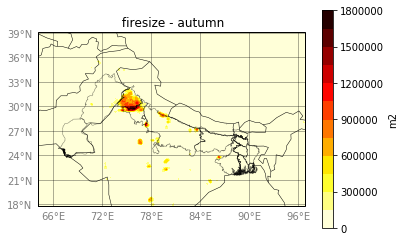

In [53]:
emi_map(t_dsf, "tot_firesize", " firesize - autumn")

## ANTHROPOGENIC

In [6]:
anthro = '/geos/d21/s1878599/IGP/inputs/autumn/wrfchemi*'
dsa = xr.open_mfdataset(anthro,concat_dim='Time')

In [10]:
dsa

<xarray.Dataset>
Dimensions:     (Time: 117, emissions_zdim_stag: 1, south_north: 119, west_east: 159)
Dimensions without coordinates: Time, emissions_zdim_stag, south_north, west_east
Data variables:
    Times       (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    XLONG       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 119, 159), meta=np.ndarray>
    XLAT        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 119, 159), meta=np.ndarray>
    E_CO        (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    E_NO        (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    E_SO2       (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), meta=np.ndarray>
    E_NH3       (Time, emissions_zdim_stag, south_north, west_east) float32 dask.array<chunksize=(1, 1, 119, 159), 

In [11]:
#Adding XLAT and XLONG to dataset
datapath ='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-10-18_00:00:00_.nc'
ds = xr.open_dataset(datapath)
#reshaping XLAT and LONG to ds anthro sizes.
lat =np.resize(ds.XLAT.values,dsa.E_CO.shape)
long =np.resize(ds.XLONG.values,dsa.E_CO.shape)

#adding to ds_fire
dsa['XLAT'] = xr.DataArray(lat, dims = dsa.dims)
dsa['XLONG'] = xr.DataArray(long, dims = dsa.dims)

In [26]:
# Adding sum up of all NMVOC
dsa["NMVOC"] = \
dsa.E_BIGALK + dsa.E_ISOP +\
dsa.E_BIGENE + dsa.E_MACR +\
dsa.E_C2H4 +   dsa.E_MVK +\
dsa.E_C2H5OH + dsa.E_HONO +\
dsa.E_C2H6  +   dsa.E_GLY +\
dsa.E_C3H8 +dsa.E_C3H6 +dsa.E_HCOOH +\
dsa.E_CH2O +      dsa.E_C2H2 +\
dsa.E_CH3CHO +   dsa.E_CH3COCH3 +\
dsa.E_CH3OH +    dsa.E_MEK +\
dsa.E_TOLUENE +  dsa.E_BENZENE +\
dsa.E_XYLENE +  dsa.E_C10H16  +\
dsa.E_MGLY 


dsa.NMVOC.attrs["units"]="mole km-2 hr-1"

In [28]:
# Adding sum up of NOx
dsa["NOx"]=dsa.E_NO + dsa.E_NO2
dsa.NOx.attrs["units"]="mole km-2 hr-1"

In [29]:
t_dsa=time_mean(dsa)

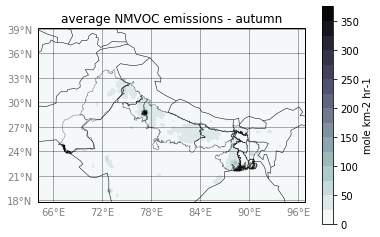

In [33]:
emi_map(t_dsa, "NMVOC", "average NMVOC emissions - autumn")

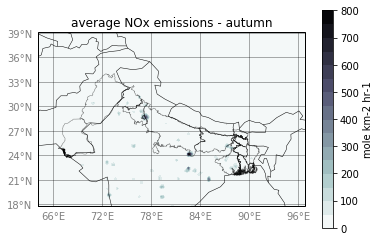

In [34]:
emi_map(t_dsa, "NOx", "average NOx emissions - autumn")

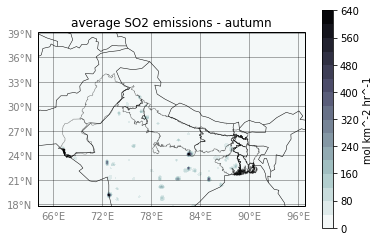

In [35]:
emi_map(t_dsa, "E_SO2", "average SO2 emissions - autumn")                                                                                                                                                                                                                                                                                                                              

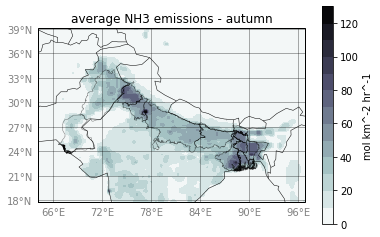

In [36]:
emi_map(t_dsa, "E_NH3", "average NH3 emissions - autumn")   

In [55]:
t_dsf.NMVOC

<xarray.DataArray 'NMVOC' (emissions_zdim_stag: 1, south_north: 119, west_east: 159)>
dask.array<mean_agg-aggregate, shape=(1, 119, 159), dtype=float32, chunksize=(1, 119, 159), chunktype=numpy.ndarray>
Dimensions without coordinates: emissions_zdim_stag, south_north, west_east
Attributes:
    units:    mole km-2 hr-1

In [58]:
st_dsf = time_mean(space_mean(dsf))
st_dsa = time_mean(space_mean(dsa))

In [67]:
st_dsf.NMVOC.values[0]

1.3234451

In [71]:
import plotly.graph_objects as go

bins=['NMVOC', 'NOx','SO2', 'NH3']

fig = go.Figure(data=[
go.Bar(name='Fire', x=bins, y=[st_dsf.NMVOC.values[0],st_dsf.NOx.values[0], st_dsf.ebu_in_so2.values[0],st_dsf.ebu_in_nh3.values[0]]),
go.Bar(name='Anthro', x=bins, y=[st_dsa.NMVOC.values[0],st_dsa.NOx.values[0], st_dsa.E_SO2.values[0],st_dsa.E_NH3.values[0]])
])
# Change the bar mode
fig.update_layout(barmode='stack',
title="Emissions all domain - autumn",
xaxis_title="species",
yaxis_title="mole km-2 hr-1")
fig.show()